In [16]:
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt

class Portfolio:
    def __init__(self, assets, cash):
        self.cash = cash
        self.ticker = assets
        self.assetPosition = {}
        self.tradeHistory = []
        for asset in assets:
            self.assetPosition[asset] = 0

    def buy(self, asset, price, amount):
        cost = price * amount
        if cost <= self.cash:
            self.cash -= cost
            self.assetPosition[asset] += amount
            self.tradeHistory.append(('BUY', asset, price, amount))
        else:
            print("Not enough capital to buy.")

    def sell(self, asset, price, amount):
        if amount <= self.assetPosition[asset]:
            self.cash += price * amount
            self.assetPosition[asset] -= amount
            self.tradeHistory.append(('SELL', asset, price, amount))
        else:
            print("Not enough position to sell.")

    def get_value(self, market_price):
        value = self.cash
        for asset in self.ticker:
            value += self.assetPosition[asset] * market_price[asset]
        return value


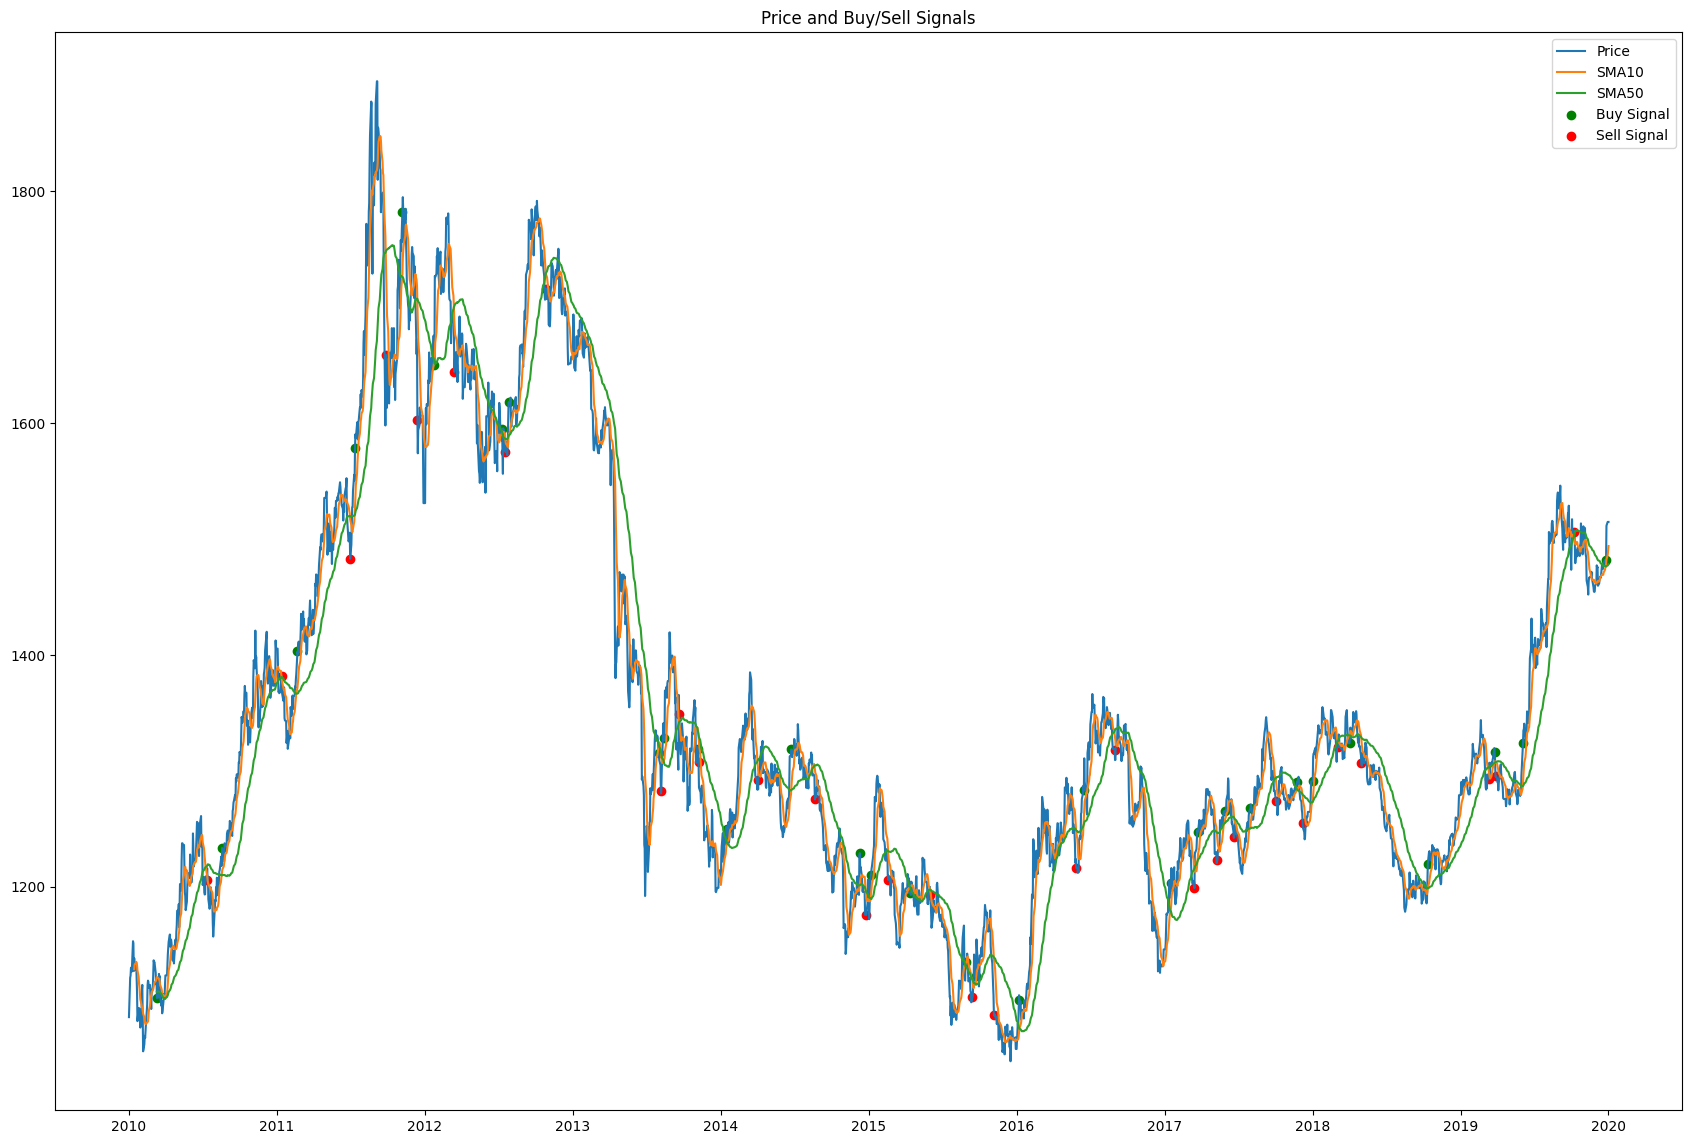

(10000.0, 14390.500000000004, 4390.500000000004, 0.2086030993159851)

In [26]:
class Backtest:
    def __init__(self, start_date, end_date, initial_cash):
        self.start_date = pd.to_datetime(start_date)
        self.end_date = pd.to_datetime(end_date)
        self.portfolio = Portfolio(['GOLD'], initial_cash)
        self.data = pd.read_csv('./data/gold/Prices_USD.csv')
        self.data['Date'] = pd.to_datetime(self.data['Date'])
        self.data = self.data[(self.data['Date'] >= self.start_date) & (self.data['Date'] <= self.end_date)]
        self.initial_cash = initial_cash

    def generate_signals(self):
        # Convert to double
        self.data['USD'] = self.data['USD'].str.replace(',', '').astype('double')
        # Calculate moving averages
        self.data['SMA10'] = talib.SMA(self.data['USD'].values, timeperiod=10)
        self.data['SMA50'] = talib.SMA(self.data['USD'].values, timeperiod=50)
        # Create a signal when the short moving average crosses the long moving average
        self.data['Signal'] = 0
        self.data.loc[self.data['SMA10'] > self.data['SMA50'], 'Signal'] = 1
        self.data['Position'] = self.data['Signal'].diff()

    def execute_trades(self):
        initial_value = self.portfolio.get_value({'GOLD': self.data.iloc[0]['USD']})
        for index, row in self.data.iterrows():
            date = row['Date']
            price = row['USD']
            if row['Position'] == 1:
                # Buy signal
                if self.portfolio.cash >= price:  # Simple condition to check if we have enough cash for at least one unit
                    self.portfolio.buy('GOLD', price, self.portfolio.cash // price)
                else:
                    # Ignore the buy signal if we don't have enough cash
                    continue
            elif row['Position'] == -1:
                # Sell signal
                if self.portfolio.assetPosition['GOLD'] > 0:
                    self.portfolio.sell('GOLD', price, self.portfolio.assetPosition['GOLD'])
        final_value = self.portfolio.get_value({'GOLD': self.data.iloc[-1]['USD']})
        return initial_value, final_value

    def calculate_performance(self, initial_value, final_value):
        pnl = final_value - initial_value
        returns = np.diff(np.log(np.array(self.data['USD'].dropna())))
        sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252)  # Annualized Sharpe Ratio
        return pnl, sharpe_ratio
    
    def plot_results(self):
        fig, ax1 = plt.subplots(figsize=(21, 14))

        # Plot the price and buy/sell signals
        ax1.plot(self.data['Date'], self.data['USD'], label='Price')
        ax1.plot(self.data['Date'], self.data['SMA10'], label='SMA10')
        ax1.plot(self.data['Date'], self.data['SMA50'], label='SMA50')
        ax1.scatter(self.data.loc[self.data['Position'] == 1, 'Date'], self.data.loc[self.data['Position'] == 1, 'USD'], color='g', label='Buy Signal')
        ax1.scatter(self.data.loc[self.data['Position'] == -1, 'Date'], self.data.loc[self.data['Position'] == -1, 'USD'], color='r', label='Sell Signal')
        ax1.legend()
        ax1.set_title('Price and Buy/Sell Signals')

        # plt.tight_layout()
        plt.show()

# Example usage
backtest = Backtest('2010-01-01', '2020-01-01', 10000)
backtest.generate_signals()
backtest.plot_results()
initial_value, final_value = backtest.execute_trades()
pnl, sharpe_ratio = backtest.calculate_performance(initial_value, final_value)
initial_value, final_value, pnl, sharpe_ratio

In [25]:
backtest.portfolio.tradeHistory

[('BUY', 'GOLD', 1104.0, 9.0),
 ('SELL', 'GOLD', 1205.5, 9.0),
 ('BUY', 'GOLD', 1233.5, 8.0),
 ('SELL', 'GOLD', 1381.5, 8.0),
 ('BUY', 'GOLD', 1403.0, 8.0),
 ('SELL', 'GOLD', 1483.0, 8.0),
 ('BUY', 'GOLD', 1579.0, 8.0),
 ('SELL', 'GOLD', 1659.0, 8.0),
 ('BUY', 'GOLD', 1782.0, 7.0),
 ('SELL', 'GOLD', 1603.0, 7.0),
 ('BUY', 'GOLD', 1650.0, 7.0),
 ('SELL', 'GOLD', 1644.3, 7.0),
 ('BUY', 'GOLD', 1595.3, 7.0),
 ('SELL', 'GOLD', 1575.3, 7.0),
 ('BUY', 'GOLD', 1618.3, 7.0),
 ('SELL', 'GOLD', 1716.0, 7.0),
 ('BUY', 'GOLD', 1315.0, 9.0),
 ('SELL', 'GOLD', 1282.5, 9.0),
 ('BUY', 'GOLD', 1328.5, 9.0),
 ('SELL', 'GOLD', 1349.3, 9.0),
 ('BUY', 'GOLD', 1319.0, 9.0),
 ('SELL', 'GOLD', 1307.3, 9.0),
 ('BUY', 'GOLD', 1250.0, 9.0),
 ('SELL', 'GOLD', 1292.0, 9.0),
 ('BUY', 'GOLD', 1318.5, 9.0),
 ('SELL', 'GOLD', 1275.3, 9.0),
 ('BUY', 'GOLD', 1229.0, 10.0),
 ('SELL', 'GOLD', 1175.8, 10.0),
 ('BUY', 'GOLD', 1210.3, 9.0),
 ('SELL', 'GOLD', 1206.0, 9.0),
 ('BUY', 'GOLD', 1194.8, 9.0),
 ('SELL', 'GOLD', 1192

In [15]:
backtest.data

,Date,USD,SMA10,SMA50,Signal,Position
8090,2010-01-01,1087.5,NaN,NaN,0,NaN
8091,2010-01-04,1121.5,NaN,NaN,0,0.0
8092,2010-01-05,1123.3,NaN,NaN,0,0.0
8093,2010-01-06,1130.0,NaN,NaN,0,0.0
8094,2010-01-07,1130.3,NaN,NaN,0,0.0
...,...,...,...,...,...,...
10694,2019-12-26,1482.1,1477.85,1476.284,1,1.0
10695,2019-12-27,1511.5,1482.34,1476.714,1,0.0
10696,2019-12-30,1514.8,1486.03,1477.176,1,0.0
10697,2019-12-31,1514.8,1489.93,1477.764,1,0.0
